## North and South Perth Housing Analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import hvplot.pandas
import requests

from config import geoapify_key 

ModuleNotFoundError: No module named 'config'

# Analysing Price Trends between South and North of Perth 

In [ ]:
# Read clean perth housing data
perth_housing_data = pd.read_csv('clean_perth_data.csv')
perth_housing_data.head()

In [ ]:
# Format DATE_SOLD to datetime. 
perth_housing_data['DATE_SOLD'] = pd.to_datetime(perth_housing_data['DATE_SOLD'])

In [ ]:
# Find the highest prices by postcode. 
max_price_postcode = pd.DataFrame(perth_housing_data.groupby(['SUBURB','POSTCODE'])['PRICE'].max())
sorted_prices = pd.DataFrame(max_price_postcode['PRICE'].sort_values(ascending=False))

In [6]:
# Top 10 Postcodes by Highest Prices
sorted_prices['PRICE'] = pd.to_numeric(sorted_prices['PRICE'])
sorted_prices['PRICE'] = sorted_prices['PRICE'].map('{:,.0f}'.format)

In [7]:
# Top 10 - Most expensive house in the top 10 postcodes
sorted_prices.head(10)

,,PRICE
SUBURB,POSTCODE,
Floreat,6014,"2,440,000"
City Beach,6015,"2,437,000"
Dalkeith,6009,"2,430,000"
Watermans Bay,6020,"2,425,000"
Peppermint Grove,6011,"2,425,000"
Mosman Park,6012,"2,425,000"
Hazelmere,6055,"2,420,000"
Applecross,6153,"2,410,000"
Swanbourne,6010,"2,400,000"


In [8]:
#Bottom 10 - Most expensive house in the bottom 10 postcodes 
sorted_prices.tail(10)

,,PRICE
SUBURB,POSTCODE,
Merriwa,6030,"455,000"
Gosnells,6110,"453,000"
Stratton,6056,"450,000"
Parmelia,6167,"448,000"
Brookdale,6112,"445,000"
Camillo,6111,"442,000"
Medina,6167,"430,000"
Koongamia,6056,"425,000"
Kwinana Town Centre,6167,"330,000"


In [9]:
# Find the top 5 postcodes by average prices. 
average_prices = pd.DataFrame(perth_housing_data.groupby(['SUBURB', 'POSTCODE'])['PRICE'].mean().round(0))
average_prices = pd.DataFrame(average_prices['PRICE'].sort_values(ascending=False))
average_prices = average_prices.rename(columns={'PRICE':"AVERAGE_PRICE"})

In [10]:
# Reset so POSTCODE is not Index 
average_prices = average_prices.reset_index(level='POSTCODE')                                                               

In [11]:
# Reset so SUBURB is not Index 
average_prices = average_prices.reset_index(level='SUBURB')    

In [12]:
average_prices.head(10)

,SUBURB,POSTCODE,AVERAGE_PRICE
0,Dalkeith,6009,1961922.0
1,Peppermint Grove,6011,1771982.0
2,Cottesloe,6011,1646283.0
3,City Beach,6015,1644756.0
4,Nedlands,6009,1639099.0
5,Swanbourne,6010,1590743.0
6,Floreat,6014,1474613.0
7,Naval Base,6165,1408000.0
8,Applecross,6153,1396130.0
9,Mosman Park,6012,1383912.0


In [13]:
average_prices.tail(10)

,SUBURB,POSTCODE,AVERAGE_PRICE
307,Camillo,6111,298090.0
308,Calista,6167,293597.0
309,Cooloongup,6168,288505.0
310,Koongamia,6056,282938.0
311,Parmelia,6167,275728.0
312,Medina,6167,270912.0
313,Haynes,6112,265126.0
314,Armadale,6112,249044.0
315,Kwinana Town Centre,6167,185598.0
316,Kwinana Beach,6167,170000.0


In [14]:
# Check how many postcodes are SOR in the top 10 average house prices 
south_count_top_10 = (average_prices.head(10)['POSTCODE'] >= 6100).value_counts()
print(south_count_top_10)

POSTCODE
False    8
True     2
Name: count, dtype: int64


In [15]:
# Check how many postcodes are SOR in the top 10 average house prices 
south_count_bottom_10 = (average_prices.tail(10)['POSTCODE'] >= 6100).value_counts()
print(south_count_bottom_10)

POSTCODE
True     9
False    1
Name: count, dtype: int64


In [16]:
average_prices = average_prices.drop_duplicates(subset='POSTCODE')

In [17]:
average_prices["LONG"] = ""
average_prices["LAT"] = ""

In [18]:
# Print a message to follow up the airport search
print("Starting Long and Lat search")

# Create a base url 
url = "https://api.geoapify.com/v1/geocode/search?"

# Create a boundary for the search 
longitude = 115.857048
latitude = -31.953512
radius = 100000

# Create a base URL 
filters = f"circle:{longitude},{latitude},{radius}"
    
# Loop through the DataFrame and search coordinates for the suburb 
for index, row in average_prices.iterrows():

    # Variables for postcode and suburb
    postcode = row["POSTCODE"]
    suburb = row["SUBURB"]
    state = "Western Australia"

    params =  { "text" : f"{postcode},{suburb},{state}, Australia",
               "filter": filters,
               "apiKey" : geoapify_key}
    # Make the API request
    response = requests.get(url=url, params=params)
    
    # Convert reponse to JSON
    response = response.json()
    
    # Extract latitude and longitude
    try:
        average_prices.loc[index, "LONG"] = response['features'][0]['properties']['lon']
        average_prices.loc[index, "LAT"] = response['features'][0]['properties']['lat']
        print(f"Coordinates for postcode {postcode} (longitude: {average_prices.loc[index, 'LONG']}, latitude: {average_prices.loc[index, 'LAT']})")
    except IndexError as e:
        print(f"{e.args[0]} not longitude or latitude found for postcode {postcode}")
              
    # Log the search results
    # print(f"Coordinates for {postcode} fetched...long {average_prices.loc[index, 'LONG']} and lat {average_prices.loc[index,"LAT"]}")
    
print("Coordinates fetching finished")
# Display sample data to confirm that the coordinates appear
average_prices.head()

Starting Long and Lat search
Coordinates for postcode 6009 (longitude: 115.7999434, latitude: -31.9956976)
Coordinates for postcode 6011 (longitude: 115.7670972, latitude: -31.9989555)
Coordinates for postcode 6015 (longitude: 115.7599058, latitude: -31.9364674)
Coordinates for postcode 6010 (longitude: 115.7666449, latitude: -31.972904)
Coordinates for postcode 6014 (longitude: 115.7939626, latitude: -31.9392096)
Coordinates for postcode 6165 (longitude: 115.7819194, latitude: -32.1954475)
Coordinates for postcode 6153 (longitude: 115.8366566, latitude: -32.0137091)
Coordinates for postcode 6012 (longitude: 115.7637593, latitude: -32.0178686)
Coordinates for postcode 6065 (longitude: 115.820817, latitude: -31.7900584)
Coordinates for postcode 6018 (longitude: 115.791731, latitude: -31.9217089)
Coordinates for postcode 6008 (longitude: 115.813926, latitude: -31.9595215)
Coordinates for postcode 6029 (longitude: 115.755874, latitude: -31.875679)
Coordinates for postcode 6007 (longitude:

,SUBURB,POSTCODE,AVERAGE_PRICE,LONG,LAT
0,Dalkeith,6009,1961922.0,115.799943,-31.995698
1,Peppermint Grove,6011,1771982.0,115.767097,-31.998956
3,City Beach,6015,1644756.0,115.759906,-31.936467
5,Swanbourne,6010,1590743.0,115.766645,-31.972904
6,Floreat,6014,1474613.0,115.793963,-31.93921


In [46]:
average_prices['LONG'] = pd.to_numeric(average_prices['LONG'], errors='coerce')
average_prices['LAT'] = pd.to_numeric(average_prices['LAT'], errors='coerce')

In [47]:
average_prices.dropna(axis=0, how='any', inplace=True)

In [48]:
average_prices.head()

,SUBURB,POSTCODE,AVERAGE_PRICE,LONG,LAT
0,Dalkeith,6009,1961922.0,115.799943,-31.995698
1,Peppermint Grove,6011,1771982.0,115.767097,-31.998956
3,City Beach,6015,1644756.0,115.759906,-31.936467
5,Swanbourne,6010,1590743.0,115.766645,-31.972904
6,Floreat,6014,1474613.0,115.793963,-31.939210


In [49]:
# Drop duplicates of postcodes 
average_prices = average_prices.drop_duplicates(subset='POSTCODE')

In [54]:
#Bottom 10 - Most expensive house in the bottom 10 postcodes 
sorted_prices.tail(10)

PRICE
SUBURB              POSTCODE         
Merriwa             6030      455,000
Gosnells            6110      453,000
Stratton            6056      450,000
Parmelia            6167      448,000
Brookdale           6112      445,000
Camillo             6111      442,000
Medina              6167      430,000
Koongamia           6056      425,000
Kwinana Town Centre 6167      330,000
Kwinana Beach       6167      170,000    return null
  }
  function is_loaded(root) {
    var Bokeh = get_bokeh(root)
    return (Bokeh != null && Bokeh.Panel !== undefined)
  }
  if (is_loaded(root)) {
    embed_document(root);
  } else {
    var attempts = 0;
    var timer = setInterval(function(root) {
      if (is_loaded(root)) {
        clearInterval(timer);
        embed_document(root);
      } else if (document.readyState == "complete") {
        attempts++;
        if (attempts > 200) {
          clearInterval(timer);
	  var Bokeh = get_bokeh(root)
	  if (Bokeh == null || Bokeh.Panel == null) {
            console.warn("Panel: ERROR: Unable to run Panel code because Bokeh or Panel library is missing");
	  } else {
	    console.warn("Panel: WARNING: Attempting to render but not all required libraries could be resolved.")
	    embed_document(root)
	  }
        }
      }
    }, 25, root)
  }
})(window);</script>

In [9]:
# Find the top 5 postcodes by average prices. 
average_prices = pd.DataFrame(perth_housing_data.groupby(['SUBURB', 'POSTCODE'])['PRICE'].mean().round(0))
average_prices = pd.DataFrame(average_prices['PRICE'].sort_values(ascending=False))
average_prices = average_prices.rename(columns={'PRICE':"AVERAGE_PRICE"})# Create map plot to revew average house prices around Perth by postcode, suburb 
coordinates = {
    "latitude": average_prices['LAT'],
    "longitude": average_prices['LONG'],
    "Suburb": average_prices['SUBURB'],
    "Average House Price": average_prices['AVERAGE_PRICE']
}

coordinates_df = pd.DataFrame(coordinates)

# Create the map plot
postcode_average_price = coordinates_df.hvplot.points(
    "longitude",
    "latitude",
    geo=True,
    tiles="OSM",
    frame_width=800,
    frame_height=500,
    size= 50, 
    alpha=0.7,
    color="Average House Price",
    title= "Distribution of Average House Prices by Postcodes",
)

# Display the map plot
postcode_average_price

In [27]:
# Divide the data into North and South of Perth. North postcode <=6000 and South postocdes >=6100
south_data = perth_housing_data.loc[(perth_housing_data['POSTCODE'] >= 6100) & (perth_housing_data['POSTCODE'] <=6200)]
north_data = perth_housing_data.loc[(perth_housing_data['POSTCODE'] <6100) & (perth_housing_data['POSTCODE'] >=6000)]

In [28]:
south_data.head()

,SUBURB,PRICE,BEDROOMS,BATHROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST
0,South Lake,565000,4,2,600,2003,18300,Cockburn Central Station,1800,2018-09-01,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,828
1,Wandi,365000,3,2,351,2013,26900,Kwinana Station,4900,2019-02-01,6167,-32.193470,115.859554,ATWELL COLLEGE,5524
2,Camillo,287000,3,1,719,1979,22600,Challis Station,1900,2015-06-01,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1649
5,Mount Richon,409000,4,2,759,1991,27300,Armadale Station,1000,2013-03-01,6112,-32.153801,116.023658,ARMADALE SENIOR HIGH SCHOOL,1227
6,Hilbert,400000,3,2,386,2014,28200,Armadale Station,3700,2016-05-01,6112,-32.179978,115.988647,DALE CHRISTIAN SCHOOL,2485


In [29]:
# Analyse data from SOR. Average house prices SOR and sort into highest to lowest. 
average_south_prices= round(pd.DataFrame(south_data.groupby(['SUBURB'])['PRICE'].mean()),2)
average_south_prices = pd.DataFrame(average_south_prices['PRICE'].sort_values(ascending=False))

In [30]:
average_south_prices.head(10)

,PRICE
SUBURB,
Naval Base,1408000.00
Applecross,1396130.14
South Perth,1215011.11
North Fremantle,1213309.52
Mount Pleasant,1211815.64
Attadale,1208154.83
Salter Point,1185205.86
Rossmoyne,1165272.85
North Coogee,1136482.05


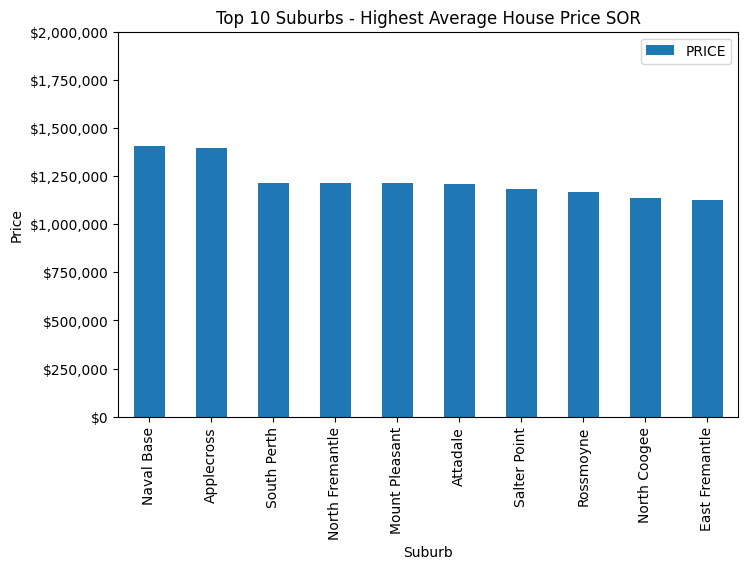

In [31]:
# Plot the top 10 suburbs average house SOR 
top_sor_plot = average_south_prices.head(10).plot(kind='bar', ylabel= "Price", ylim=(0,2000000), xlabel = "Suburb", figsize=(8,5), title= "Top 10 Suburbs - Highest Average House Price SOR")
top_sor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

In [32]:
# Analyse data from NOR. Average house prices NOR and sort into highest to lowest. 
average_north_prices= round(pd.DataFrame(north_data.groupby(['SUBURB'])['PRICE'].mean()),2)
average_north_prices = pd.DataFrame(average_north_prices['PRICE'].sort_values(ascending=False))

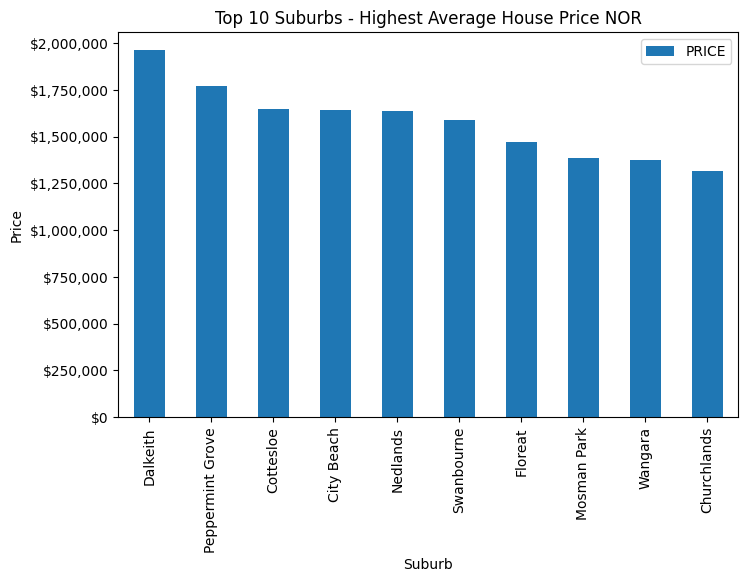

In [33]:
# Plot the Top 10 Suburbs house NOR
top_nor_plot = average_north_prices.head(10).plot(kind='bar', ylabel= "Price", xlabel = "Suburb", figsize=(8,5), title= "Top 10 Suburbs - Highest Average House Price NOR")
top_nor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

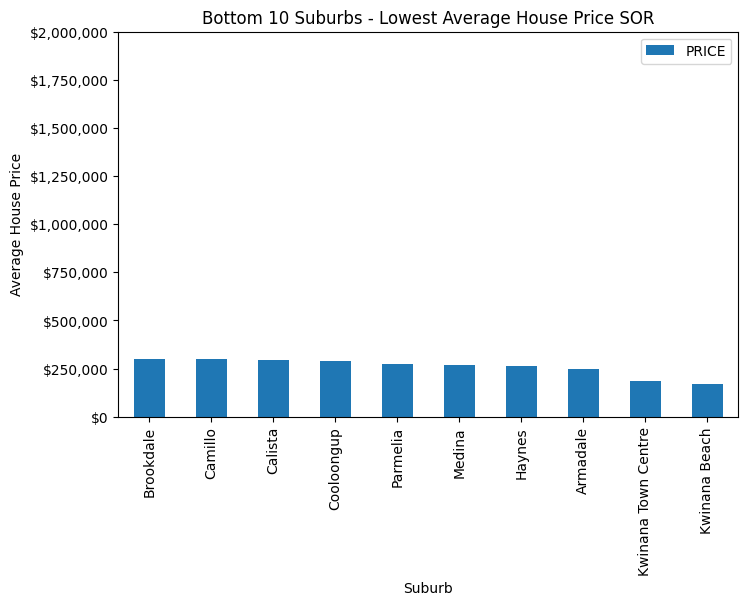

In [34]:
# Plot the Bottom 10 Suburbs house SOR 
bottom_sor_plot = average_south_prices.tail(10).plot(kind='bar', ylabel= "Average House Price", xlabel = "Suburb", ylim= (0,2000000), figsize=(8,5), title= "Bottom 10 Suburbs - Lowest Average House Price SOR")
bottom_sor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

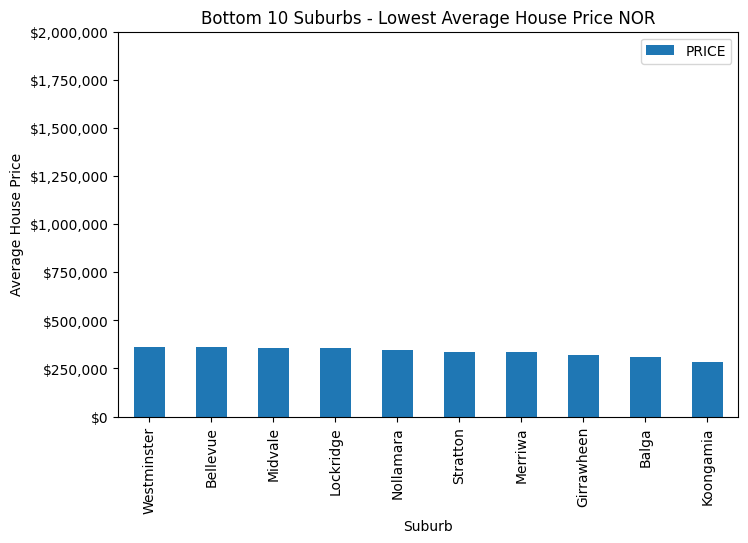

In [35]:
# Plot the Bottom 10 Suburbs house NOR 
bottom_nor_plot = average_north_prices.tail(10).plot(kind='bar', ylabel= "Average House Price", xlabel = "Suburb", ylim= (0,2000000), figsize=(8,5), title= "Bottom 10 Suburbs - Lowest Average House Price NOR")
bottom_nor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

In [36]:
# Extract the year only from the DATE_SOLD column. 
south_data['YEAR_SOLD'] = south_data['DATE_SOLD'].dt.year 
north_data['YEAR_SOLD'] = north_data['DATE_SOLD'].dt.year 

C:\Users\jesss\AppData\Local\Temp\ipykernel_17592\2166554490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_data['YEAR_SOLD'] = north_data['DATE_SOLD'].dt.year


In [37]:
# Compare average house prices between NOR and SOR average over the years 
sor_average_price_by_year = south_data.groupby(['YEAR_SOLD'])['PRICE'].mean()
nor_average_price_by_year = north_data.groupby(['YEAR_SOLD'])['PRICE'].mean()

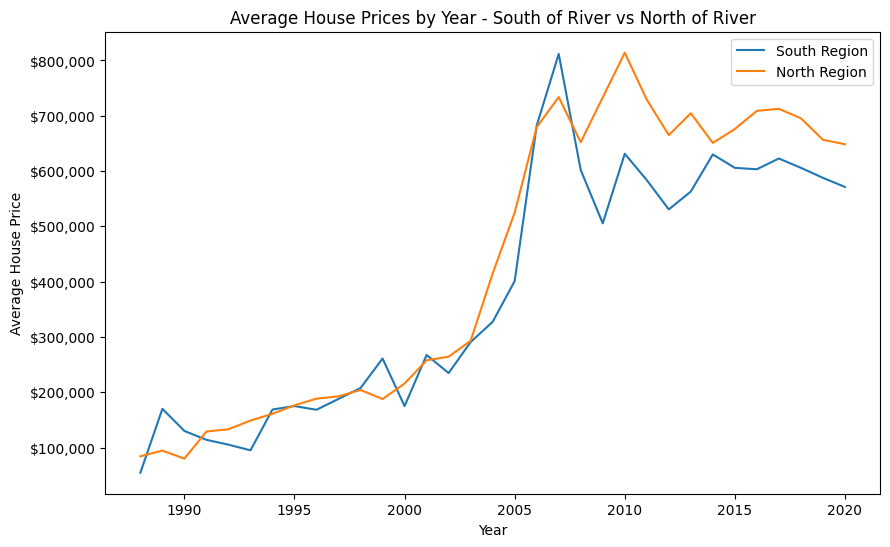

In [38]:
# Plotting the South region data as a line
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(sor_average_price_by_year.index, sor_average_price_by_year, label='South Region')

# Plotting the North region data as a line
ax1.plot(nor_average_price_by_year.index, nor_average_price_by_year, label='North Region')

# Adding labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Average House Price')
ax1.set_title('Average House Prices by Year - South of River vs North of River')
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

# Adding a legend
ax1.legend()

# Display the plot
plt.show()

In [39]:
# Create bins to determine a range of average prices and which suburb have the range of prices 
# Bins are 0, 300000, 500000, 800000, 1000000, 150000, 2000000, 2500000.   
bins = [0, 300000, 500000, 800000, 1000000, 1500000, 2000000]

# Create the names for the five bins
price_range = ["0 - $300k", "$300k - $500k", "$500k - $800k", "$800k - $1M", "$1m - $1.5m", "$1.5m - $2m"] 


In [40]:
# # Slice the data and place it into bins. Find sububrbs in NOR that are within certain price ranges.  
average_north_prices["PRICE_RANGE"] = pd.cut(average_north_prices['PRICE'], bins=bins , labels=price_range, include_lowest=True)
nor_price_ranges = average_north_prices.reset_index(level='SUBURB').set_index('PRICE_RANGE')
nor_price_ranges = nor_price_ranges.rename(columns={'PRICE': 'AVERAGE_PRICE'})
nor_price_ranges['AVERAGE_PRICE'] = nor_price_ranges['AVERAGE_PRICE'].map('${:,.0f}'.format)

In [41]:
# Find sububrbs in SOR that are within certain price ranges. 
average_south_prices["PRICE_RANGE"] = pd.cut(average_south_prices['PRICE'], bins=bins , labels=price_range, include_lowest=True)
sor_price_ranges = average_south_prices.reset_index(level='SUBURB').set_index('PRICE_RANGE')
sor_price_ranges = sor_price_ranges.rename(columns={'PRICE': 'AVERAGE_PRICE'})
sor_price_ranges['AVERAGE_PRICE'] = sor_price_ranges['AVERAGE_PRICE'].map('${:,.0f}'.format)

In [42]:
# Top 10 suburbs NOR- Top price range
nor_price_ranges.head()

,SUBURB,AVERAGE_PRICE
PRICE_RANGE,,
$1.5m - $2m,Dalkeith,"$1,961,922"
$1.5m - $2m,Peppermint Grove,"$1,771,982"
$1.5m - $2m,Cottesloe,"$1,646,283"
$1.5m - $2m,City Beach,"$1,644,756"
$1.5m - $2m,Nedlands,"$1,639,099"


In [43]:
# Top 10 suburbs - Top price range 
sor_price_ranges.head()

,SUBURB,AVERAGE_PRICE
PRICE_RANGE,,
$1m - $1.5m,Naval Base,"$1,408,000"
$1m - $1.5m,Applecross,"$1,396,130"
$1m - $1.5m,South Perth,"$1,215,011"
$1m - $1.5m,North Fremantle,"$1,213,310"
$1m - $1.5m,Mount Pleasant,"$1,211,816"


In [44]:
# Bottom 10 suburbs NOR- lowest price range
nor_price_ranges.tail()

,SUBURB,AVERAGE_PRICE
PRICE_RANGE,,
$300k - $500k,Stratton,"$337,497"
$300k - $500k,Merriwa,"$333,589"
$300k - $500k,Girrawheen,"$318,077"
$300k - $500k,Balga,"$310,759"
0 - $300k,Koongamia,"$282,938"


In [45]:
# Bottom 10 suburbs SOR - lower price range 
sor_price_ranges.tail()

,SUBURB,AVERAGE_PRICE
PRICE_RANGE,,
0 - $300k,Medina,"$270,912"
0 - $300k,Haynes,"$265,126"
0 - $300k,Armadale,"$249,044"
0 - $300k,Kwinana Town Centre,"$185,598"
0 - $300k,Kwinana Beach,"$170,000"
